In [2]:
import pandas as pd
import numpy as np
import os
import os.path as osp

import torchio as tio
from pathlib import Path
from scipy.interpolate import PchipInterpolator, interp1d
from matplotlib import pyplot as plt
from scipy.stats import norm

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [19]:
internal_data_pths = [
                      '/nas/yirui.wang/datasets/LN_classify/Fudan_HN_LN_22-23_all/Fudan_HN_LN_20231204_patches',
                      ]

external_data_pths = ['/nas/yirui.wang/datasets/LN_classify/Fudan_HN_LN_22-23_all/CGMH/CGMH_2024_patches',
                      '/nas/yirui.wang/datasets/LN_classify/Fudan_HN_LN_22-23_all/TCGA/TCGA-HNSC_selected_patches',
                      '/nas/yirui.wang/datasets/LN_classify/Fudan_HN_LN_22-23_all/CGMH_Oral/CGMH_Oral_patches'
                      ]

name_to_sad = {}
LN_list_per_patient = {}
total_LN_per_patient = {}
for data_idx, crop_pth in enumerate(internal_data_pths + external_data_pths):
    cropfile = osp.join(crop_pth, "cropping_list.csv")
    df = pd.read_csv(cropfile)
    for idx, row in df.iterrows():
        name_to_sad[row['basename'].lower()] = float(row['recist'])

        patient_id = row['basename'].lower().split('_ins')[0]
        ln_id = int(row['basename'].lower().split('_ins')[1])
        if patient_id not in LN_list_per_patient:
            LN_list_per_patient[patient_id] = []
        LN_list_per_patient[patient_id].append(ln_id)

In [48]:
_MIN_SAD = 5.0
# _MAX_SAD = {'EENT': 21.8850, 'CGMH': 11.25, 'TCGA': 9999, 'CGMH-Oral': 9999, 'Dev': 9999} # q50 limit
_MAX_SAD = {'EENT': 9999, 'CGMH': 9999, 'TCGA': 9999, 'CGMH-Oral': 9999, 'Dev': 9999} # no limit
renji_ln_count = {}
renji_ln_rm = {}
cgmh_ln_count = {}
cgmh_ln_rm = {}
tcga_ln_count = {}
tcga_ln_rm = {}

# renji_pth = "/nas/yirui.wang/datasets/LN_classify/Fudan_HN_LN_22-23_all/Fudan_HN_LN_20231204/2023-08_LN_data_reorganize_external"
renji_pth = "/nas/yirui.wang/datasets/LN_classify/Fudan_HN_LN_22-23_all/Fudan_HN_LN_20231204_patches/Ext"
# cgmg_pth = "/nas/yirui.wang/datasets/LN_classify/Fudan_HN_LN_22-23_all/CGMH/CGMH_2024_reoriented"
cgmh_pth = "/nas/yirui.wang/datasets/LN_classify/Fudan_HN_LN_22-23_all/CGMH/CGMH_2024_patches"
# tcga_pth = "/nas/yirui.wang/datasets/LN_classify/Fudan_HN_LN_22-23_all/TCGA/TCGA-HNSC_selected_reori_labeled"
tcga_pth = "/nas/yirui.wang/datasets/LN_classify/Fudan_HN_LN_22-23_all/TCGA/TCGA-HNSC_selected_patches"

for p in Path(renji_pth).rglob("*_mask.nii.gz"):
    basename = osp.basename(p).replace("_mask.nii.gz", "")
    patient = basename.split('_ins')[0]
    ln_id = int(basename.split('_ins')[-1].split('_')[0])
    if '_pos' in basename:
        sad = name_to_sad[basename.lower().split('_pos')[0]]
    else:
        sad = name_to_sad[basename.lower().split('_neg')[0]]
    
    if patient not in renji_ln_count:
        renji_ln_count[patient] = []
        renji_ln_rm[patient] = []
    
    if sad >= 5 or '_pos' in basename:
        renji_ln_count[patient].append(ln_id)
    else:
        renji_ln_rm[patient].append(ln_id)

for p in Path(cgmh_pth).rglob("*_mask.nii.gz"):
    basename = osp.basename(p).replace("_mask.nii.gz", "")
    patient = basename.split('_ins')[0]
    ln_id = int(basename.split('_ins')[-1].split('_')[0])
    if '_pos' in basename:
        sad = name_to_sad[basename.lower().split('_pos')[0]]
    else:
        sad = name_to_sad[basename.lower().split('_neg')[0]]
    
    if patient not in cgmh_ln_count:
        cgmh_ln_count[patient] = []
        cgmh_ln_rm[patient] = []
    
    if sad >= 5 or '_pos' in basename:
        cgmh_ln_count[patient].append(ln_id)
    else:
        cgmh_ln_rm[patient].append(ln_id)
    
for p in Path(tcga_pth).rglob("*_mask.nii.gz"):
    basename = osp.basename(p).replace("_mask.nii.gz", "")
    patient = basename.split('_ins')[0]
    ln_id = int(basename.split('_ins')[-1].split('_')[0])
    if '_pos' in basename:
        sad = name_to_sad[basename.lower().split('_pos')[0]]
    else:
        sad = name_to_sad[basename.lower().split('_neg')[0]]
    
    if patient not in tcga_ln_count:
        tcga_ln_count[patient] = []
        tcga_ln_rm[patient] = []
    
    if sad >= 5 or '_pos' in basename:
        tcga_ln_count[patient].append(ln_id)
    else:
        tcga_ln_rm[patient].append(ln_id)

#### Load annotations

In [5]:
renji_anno_pth = "/nas/yirui.wang/datasets/LN_classify/Fudan_HN_LN_22-23_all/Fudan_HN_LN_20231204/headNeck_LN_label_infor(7).csv"
cgmh_anno_pth = "/nas/yirui.wang/datasets/LN_classify/Fudan_HN_LN_22-23_all/CGMH/headNeck_LN_label_infor.csv"
tcga_anno_pth = "/nas/yirui.wang/datasets/LN_classify/Fudan_HN_LN_22-23_all/TCGA/headNeck_LN_label_infor.csv"
df_renji = pd.read_csv(renji_anno_pth)
df_cgmh = pd.read_csv(cgmh_anno_pth)
df_tcga = pd.read_csv(tcga_anno_pth)

In [6]:
# Load reader 1 and reader 2's annotation
rd1_renji_pth = "/nas/yirui.wang/datasets/LN_classify/Fudan_HN_LN_22-23_all/ReaderStudy/reader1_renji_remapped.csv"
rd1_cgmh_pth = "/nas/yirui.wang/datasets/LN_classify/Fudan_HN_LN_22-23_all/ReaderStudy/reader1_cgmh.csv"
rd1_tcga_pth = "/nas/yirui.wang/datasets/LN_classify/Fudan_HN_LN_22-23_all/ReaderStudy/reader1_tcga_remapped.csv"
df_rd1_renji = pd.read_csv(rd1_renji_pth)
df_rd1_cgmh = pd.read_csv(rd1_cgmh_pth)
df_rd1_tcga = pd.read_csv(rd1_tcga_pth)

rd2_renji_pth = "/nas/yirui.wang/datasets/LN_classify/Fudan_HN_LN_22-23_all/ReaderStudy/reader2_renji_remapped.csv"
rd2_cgmh_pth = "/nas/yirui.wang/datasets/LN_classify/Fudan_HN_LN_22-23_all/ReaderStudy/reader2_cgmh.csv"
rd2_tcga_pth = "/nas/yirui.wang/datasets/LN_classify/Fudan_HN_LN_22-23_all/ReaderStudy/reader2_tcga_remapped.csv"
df_rd2_renji = pd.read_csv(rd2_renji_pth)
df_rd2_cgmh = pd.read_csv(rd2_cgmh_pth)
df_rd2_tcga = pd.read_csv(rd2_tcga_pth)

rd3_renji_pth = "/nas/yirui.wang/datasets/LN_classify/Fudan_HN_LN_22-23_all/ReaderStudy/reader3_sn_renji_remapped.csv"
rd3_cgmh_pth = "/nas/yirui.wang/datasets/LN_classify/Fudan_HN_LN_22-23_all/ReaderStudy/reader3_sn_cgmh.csv"
rd3_tcga_pth = "/nas/yirui.wang/datasets/LN_classify/Fudan_HN_LN_22-23_all/ReaderStudy/reader3_sn_tcga_remapped.csv"
df_rd3_renji = pd.read_csv(rd3_renji_pth)
df_rd3_cgmh = pd.read_csv(rd3_cgmh_pth)
df_rd3_tcga = pd.read_csv(rd3_tcga_pth)

rd4_renji_pth = "/nas/yirui.wang/datasets/LN_classify/Fudan_HN_LN_22-23_all/ReaderStudy/reader4_dd_renji_remapped.csv"
rd4_cgmh_pth = "/nas/yirui.wang/datasets/LN_classify/Fudan_HN_LN_22-23_all/ReaderStudy/reader4_dd_cgmh.csv"
rd4_tcga_pth = "/nas/yirui.wang/datasets/LN_classify/Fudan_HN_LN_22-23_all/ReaderStudy/reader4_dd_tcga_remapped.csv"
df_rd4_renji = pd.read_csv(rd4_renji_pth)
df_rd4_cgmh = pd.read_csv(rd4_cgmh_pth)
df_rd4_tcga = pd.read_csv(rd4_tcga_pth)

rd5_renji_pth = "/nas/yirui.wang/datasets/LN_classify/Fudan_HN_LN_22-23_all/ReaderStudy/reader5_xbb_renji_remapped.csv"
rd5_cgmh_pth = "/nas/yirui.wang/datasets/LN_classify/Fudan_HN_LN_22-23_all/ReaderStudy/reader5_xbb_cgmh.csv"
rd5_tcga_pth = "/nas/yirui.wang/datasets/LN_classify/Fudan_HN_LN_22-23_all/ReaderStudy/reader5_xbb_tcga_remapped.csv"
df_rd5_renji = pd.read_csv(rd5_renji_pth)
df_rd5_cgmh = pd.read_csv(rd5_cgmh_pth)
df_rd5_tcga = pd.read_csv(rd5_tcga_pth)

rd6_renji_pth = "/nas/yirui.wang/datasets/LN_classify/Fudan_HN_LN_22-23_all/ReaderStudy/reader6_albert_renji_remapped.csv"
rd6_cgmh_pth = "/nas/yirui.wang/datasets/LN_classify/Fudan_HN_LN_22-23_all/ReaderStudy/reader6_albert_cgmh.csv"
rd6_tcga_pth = "/nas/yirui.wang/datasets/LN_classify/Fudan_HN_LN_22-23_all/ReaderStudy/reader6_albert_tcga_remapped.csv"
df_rd6_renji = pd.read_csv(rd6_renji_pth)
df_rd6_cgmh = pd.read_csv(rd6_cgmh_pth)
df_rd6_tcga = pd.read_csv(rd6_tcga_pth)

In [46]:
def generate_reader_confusion_mat(df_reader, df_anno, dataset):
    rater_met_res = []
    rater_ene_res = []
    gt_met = []
    gt_ene = []
    read_order = []

    for idx, reader_row in df_reader.iterrows():
        patient = reader_row["file_name"].replace(".nii.gz", "")
        ln_id2idx = {}
        if dataset == 'renji':
            patient_annotations = len(renji_ln_count[patient])
            all_lns = set(renji_ln_count[patient])
            sorted_ids = sorted(renji_ln_count[patient])
            for idx, ln_id in enumerate(sorted_ids):
                ln_id2idx[ln_id] = idx
        elif dataset == 'cgmh':
            if 'CGMH_Larynx20240117_anon_025' in patient:
                continue
            patient_annotations = len(cgmh_ln_count[patient])
            all_lns = set(cgmh_ln_count[patient])
            sorted_ids = sorted(cgmh_ln_count[patient])
            for idx, ln_id in enumerate(sorted_ids):
                ln_id2idx[ln_id] = idx
        elif dataset == 'tcga':
            patient_annotations = len(tcga_ln_count[patient])
            all_lns = set(tcga_ln_count[patient])
            sorted_ids = sorted(tcga_ln_count[patient])
            for idx, ln_id in enumerate(sorted_ids):
                ln_id2idx[ln_id] = idx
        else:
            raise ValueError("Invalid type")
            
        row_meta_preds = reader_row["positive_LN_id"]
        if isinstance(row_meta_preds, pd.Series):
            row_meta_preds = row_meta_preds.values[0]
        
        if isinstance(row_meta_preds, float) and np.isnan(row_meta_preds):
            meta_preds = []
        elif isinstance(row_meta_preds, (int, float)):
            meta_preds = [int(row_meta_preds)]
        elif isinstance(row_meta_preds, str) and row_meta_preds != "无转移" and row_meta_preds != "":
            meta_preds = [int(p) for p in row_meta_preds.rstrip(',').split(",")]
        elif row_meta_preds == "无转移" or row_meta_preds == "":
            meta_preds = []
        else:
            raise ValueError("No predicted found")
        
        # remove not selected LNs (e.g., <5mm negative and >LIMIT ENEs)
        if dataset == 'renji':
            meta_preds = [p for p in meta_preds if p not in renji_ln_rm[patient]]
        elif dataset == 'cgmh':
            meta_preds = [p for p in meta_preds if p not in cgmh_ln_rm[patient]]
        elif dataset == 'tcga':
            meta_preds = [p for p in meta_preds if p not in tcga_ln_rm[patient]]
        
        row_ene_preds = reader_row["ENE_LN_id"]
        if isinstance(row_ene_preds, pd.Series):
            row_ene_preds = row_ene_preds.values[0]
          
        if isinstance(row_ene_preds, float) and np.isnan(row_ene_preds):
            ene_preds = []
        elif isinstance(row_ene_preds, (int, float)):
            ene_preds = [int(row_ene_preds)]
        elif isinstance(row_ene_preds, str):
            ene_preds = [int(p) for p in row_ene_preds.rstrip(',').split(",")]
        else:
            ene_preds = []
        
        # remove not selected LNs (e.g., <5mm negative and >LIMIT ENEs)
        if dataset == 'renji':
            ene_preds = [p for p in ene_preds if p not in renji_ln_rm[patient]]
        elif dataset == 'cgmh':
            ene_preds = [p for p in ene_preds if p not in cgmh_ln_rm[patient]]
        elif dataset == 'tcga':
            ene_preds = [p for p in ene_preds if p not in tcga_ln_rm[patient]]
        
        anno_row = df_anno[df_anno["file_name"] == patient]
        if anno_row.empty:
            print("{} is not matched any annotation".format(patient))
            continue
        
        row_anno_meta = anno_row["positive_LN_id"]
        if isinstance(row_anno_meta, pd.Series):
            row_anno_meta = row_anno_meta.values[0]
        
        if isinstance(row_anno_meta, float) and np.isnan(row_anno_meta):
            anno_meta = []
        elif isinstance(row_anno_meta, (int, float)):
            anno_meta = [int(row_anno_meta)]
        elif isinstance(row_anno_meta, str) and row_anno_meta != "无转移":
            anno_meta = [int(p) for p in row_anno_meta.rstrip(',').split(",")]
        elif row_anno_meta == "无转移":
            anno_meta = []
        else:
            raise ValueError("No annotation found")
        
        # remove not selected LNs (e.g., <5mm negative and >LIMIT ENEs)
        if dataset == 'renji':
            anno_meta = [p for p in anno_meta if p not in renji_ln_rm[patient]]
        elif dataset == 'cgmh':
            anno_meta = [p for p in anno_meta if p not in cgmh_ln_rm[patient]]
        elif dataset == 'tcga':
            anno_meta = [p for p in anno_meta if p not in tcga_ln_rm[patient]]
        
        row_anno_ene = anno_row["ENE_LN_id"]
        if isinstance(row_anno_ene, pd.Series):
            row_anno_ene = row_anno_ene.values[0]
          
        if isinstance(row_anno_ene, float) and np.isnan(row_anno_ene):
            anno_ene = []
        elif isinstance(row_anno_ene, (int, float)):
            anno_ene = [int(row_anno_ene)]
        elif isinstance(row_anno_ene, str):
            anno_ene = [int(p) for p in row_anno_ene.rstrip(',').split(",")]
        else:
            anno_ene = []
        
        # remove not selected LNs (e.g., <5mm negative and >LIMIT ENEs)
        if dataset == 'renji':
            anno_ene = [p for p in anno_ene if p not in renji_ln_rm[patient]]
        elif dataset == 'cgmh':
            anno_ene = [p for p in anno_ene if p not in cgmh_ln_rm[patient]]
        elif dataset == 'tcga':
            anno_ene = [p for p in anno_ene if p not in tcga_ln_rm[patient]]
            
        meta_pred_idx = [ln_id2idx[p] for p in meta_preds if p in all_lns]
        ene_preds_idx = [ln_id2idx[p] for p in ene_preds if p in all_lns]
        meta_anno_idx = [ln_id2idx[p] for p in anno_meta]
        ene_anno_idx = [ln_id2idx[p] for p in anno_ene]
        
        # prepare for inter-rater reliability
        read_order.append(patient)
        meta_read_res = np.zeros(patient_annotations).astype(int)
        ene_read_res = np.zeros(patient_annotations).astype(int)
        meta_read_res[list(meta_pred_idx)] = 1
        ene_read_res[list(ene_preds_idx)] = 1
        rater_met_res.append(meta_read_res)
        rater_ene_res.append(ene_read_res)

        # prepare for GT vector
        patient_met_gt = np.zeros(patient_annotations).astype(int)
        patient_ene_gt = np.zeros(patient_annotations).astype(int)
        patient_met_gt[meta_anno_idx] = 1
        patient_ene_gt[ene_anno_idx] = 1
        gt_met.append(patient_met_gt)
        gt_ene.append(patient_ene_gt)
    
    rater_met_res = np.concatenate(rater_met_res, axis=0)
    rater_ene_res = np.concatenate(rater_ene_res, axis=0)

    gt_met = np.concatenate(gt_met, axis=0)
    gt_ene = np.concatenate(gt_ene, axis=0)

    rater_met_cm = confusion_matrix(gt_met, rater_met_res, labels=[0, 1], normalize='true')

    if dataset != "tcga":
        rater_ene_cm = confusion_matrix(gt_ene, rater_ene_res, labels=[0, 1], normalize='true')
    else:
        rater_ene_cm = None
    

    return rater_met_cm, rater_ene_cm


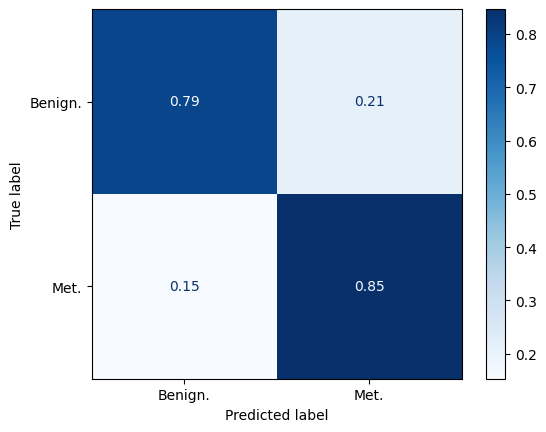

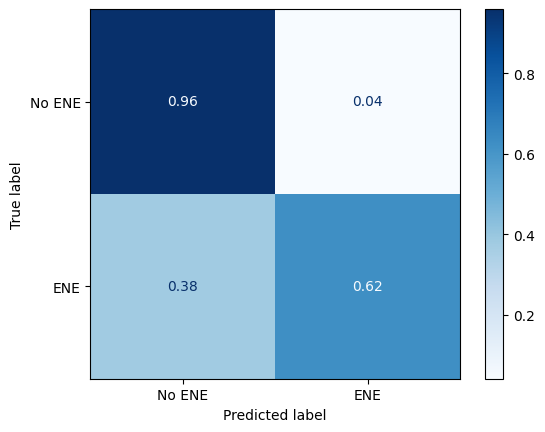

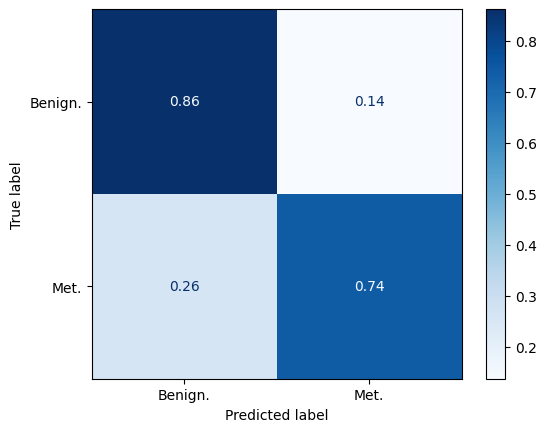

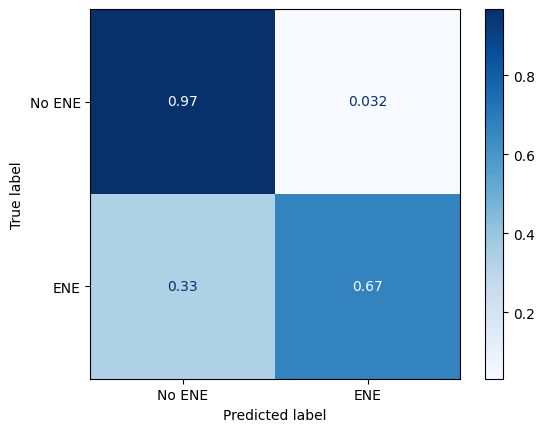

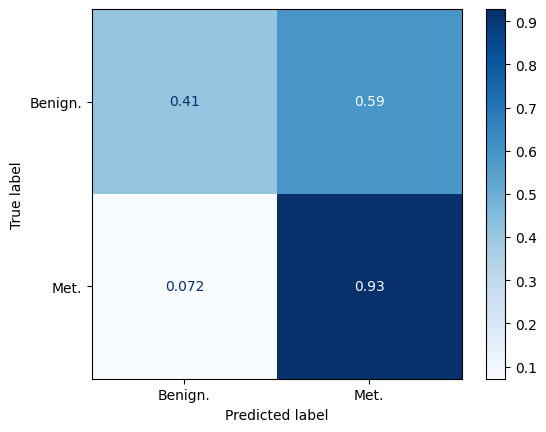

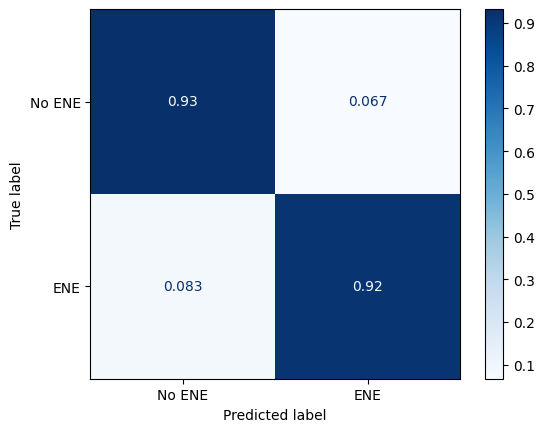

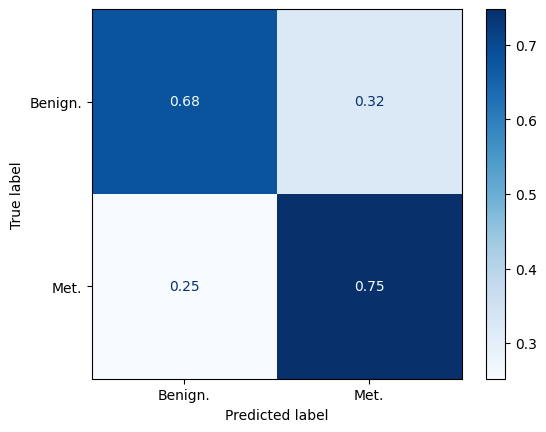

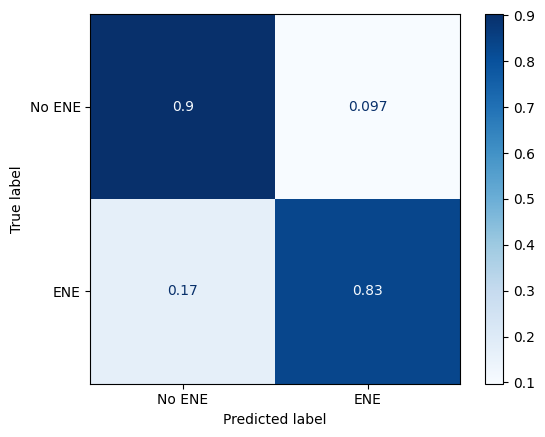

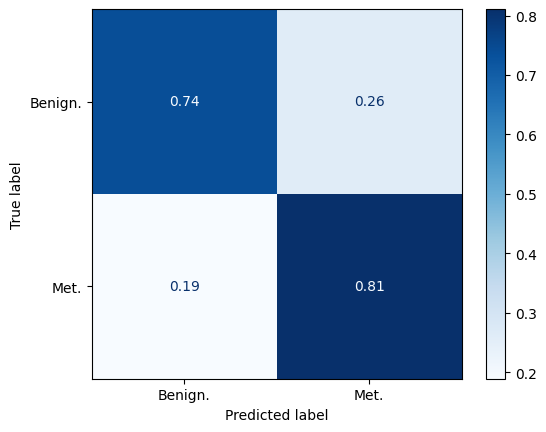

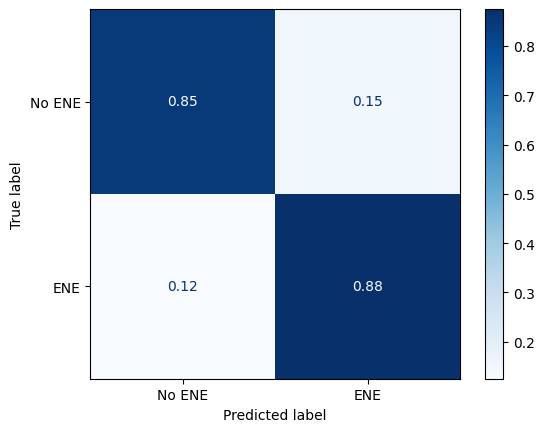

In [50]:
# EENT
renji_r1_met_cm, renji_r1_ene_cm = generate_reader_confusion_mat(df_rd1_renji, df_renji, dataset='renji')
renji_r2_met_cm, renji_r2_ene_cm = generate_reader_confusion_mat(df_rd2_renji, df_renji, dataset='renji')
renji_r4_met_cm, renji_r4_ene_cm = generate_reader_confusion_mat(df_rd4_renji, df_renji, dataset='renji')
renji_r5_met_cm, renji_r5_ene_cm = generate_reader_confusion_mat(df_rd5_renji, df_renji, dataset='renji')
renji_r6_met_cm, renji_r6_ene_cm = generate_reader_confusion_mat(df_rd6_renji, df_renji, dataset='renji')

for ridx in [1,2,4,5,6]:
    disp = ConfusionMatrixDisplay(confusion_matrix=eval("renji_r{}_met_cm".format(ridx)), display_labels=['Benign.', 'Met.'])
    disp.plot(cmap=plt.cm.Blues)
    plt.savefig("renji_met_reader{}.svg".format(ridx))

    disp = ConfusionMatrixDisplay(confusion_matrix=eval("renji_r{}_ene_cm".format(ridx)), display_labels=['No ENE', 'ENE'])
    disp.plot(cmap=plt.cm.Blues)
    plt.savefig("renji_ene_reader{}.svg".format(ridx))

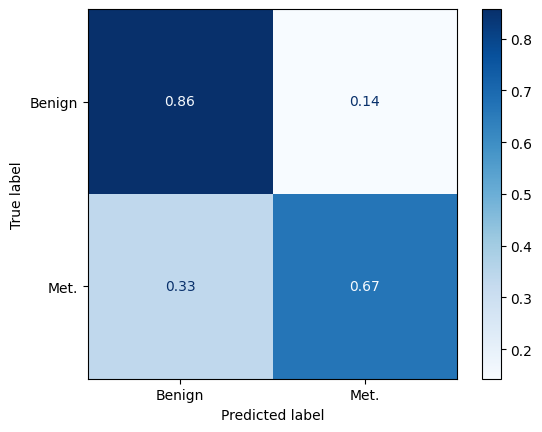

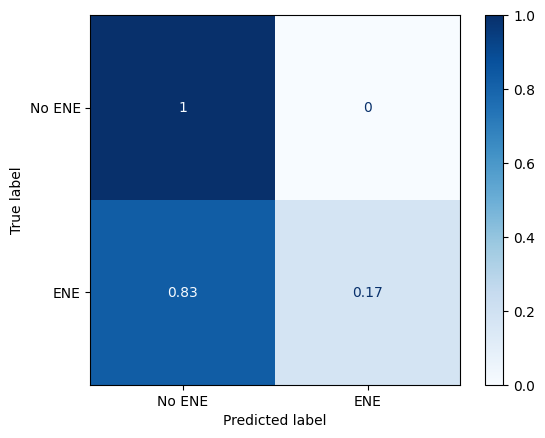

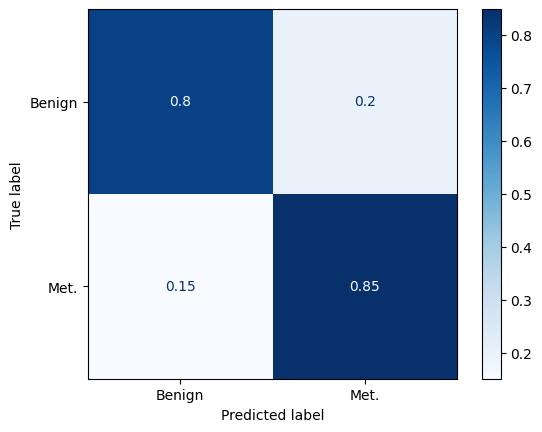

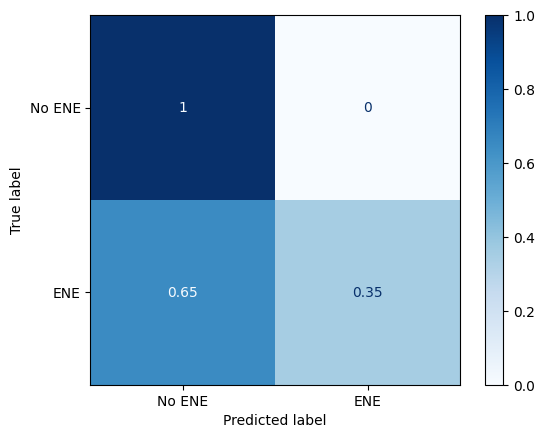

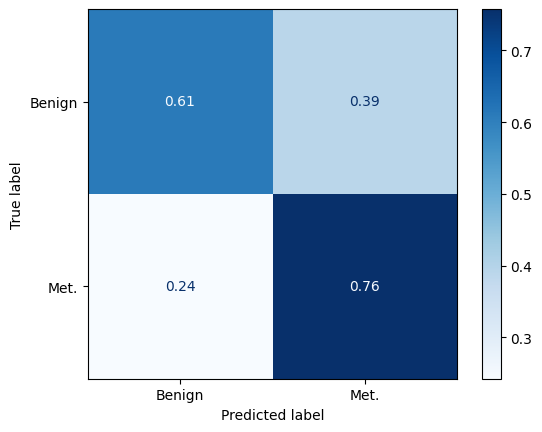

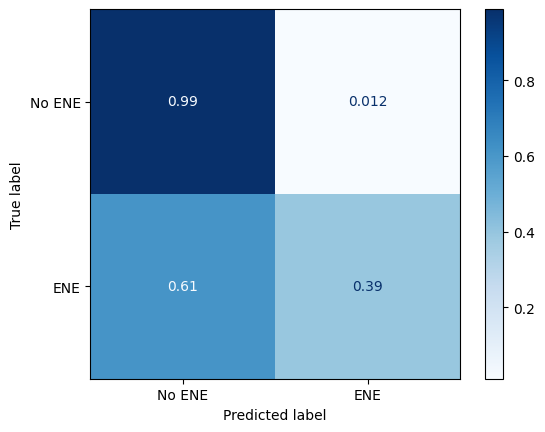

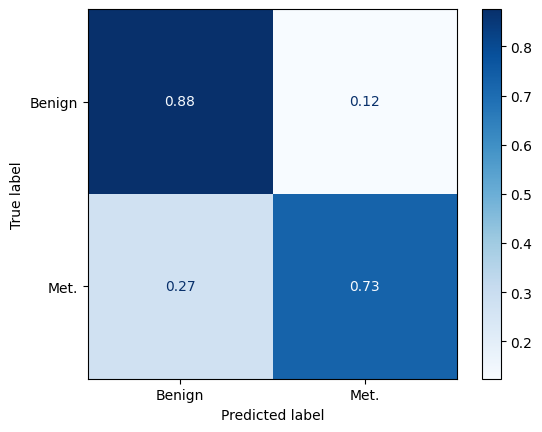

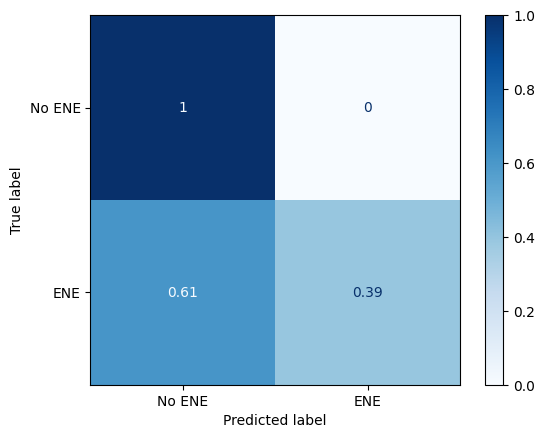

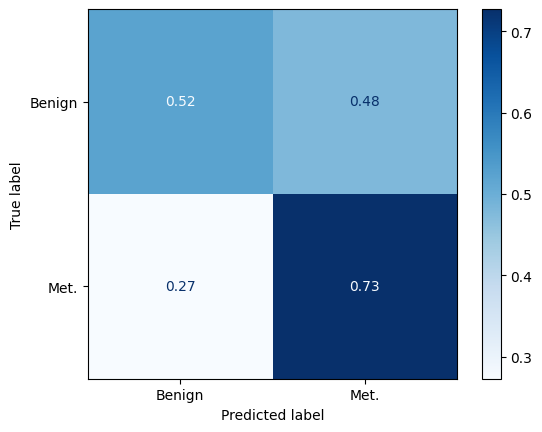

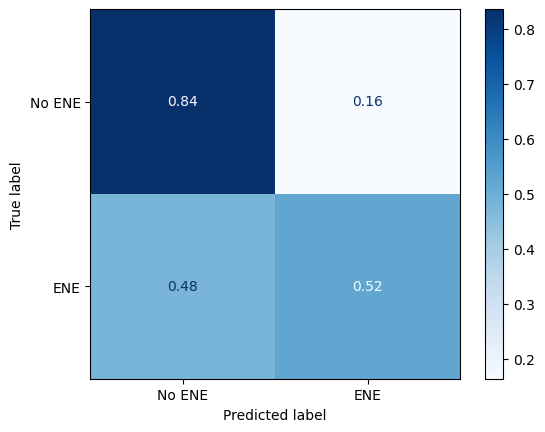

In [53]:
# CGMH
cgmh_r1_met_cm, cgmh_r1_ene_cm = generate_reader_confusion_mat(df_rd1_cgmh, df_cgmh, dataset='cgmh')
cgmh_r2_met_cm, cgmh_r2_ene_cm = generate_reader_confusion_mat(df_rd2_cgmh, df_cgmh, dataset='cgmh')
cgmh_r4_met_cm, cgmh_r4_ene_cm = generate_reader_confusion_mat(df_rd4_cgmh, df_cgmh, dataset='cgmh')
cgmh_r5_met_cm, cgmh_r5_ene_cm = generate_reader_confusion_mat(df_rd5_cgmh, df_cgmh, dataset='cgmh')
cgmh_r6_met_cm, cgmh_r6_ene_cm = generate_reader_confusion_mat(df_rd6_cgmh, df_cgmh, dataset='cgmh')

for ridx in [1,2,4,5,6]:
    disp = ConfusionMatrixDisplay(confusion_matrix=eval("cgmh_r{}_met_cm".format(ridx)), display_labels=['Benign', 'Met.'])
    disp.plot(cmap=plt.cm.Blues)
    plt.savefig("cgmh_met_reader{}.svg".format(ridx))

    disp = ConfusionMatrixDisplay(confusion_matrix=eval("cgmh_r{}_ene_cm".format(ridx)), display_labels=['No ENE', 'ENE'])
    disp.plot(cmap=plt.cm.Blues)
    plt.savefig("cgmh_ene_reader{}.svg".format(ridx))

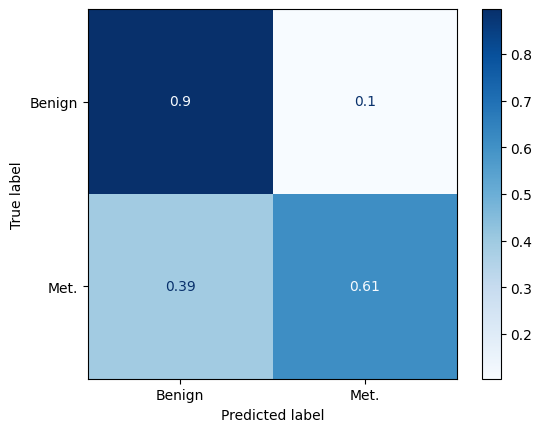

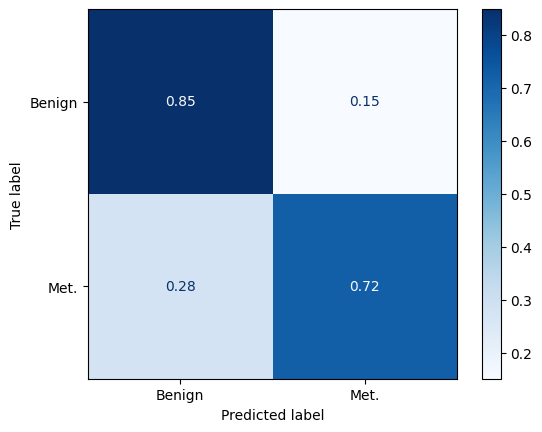

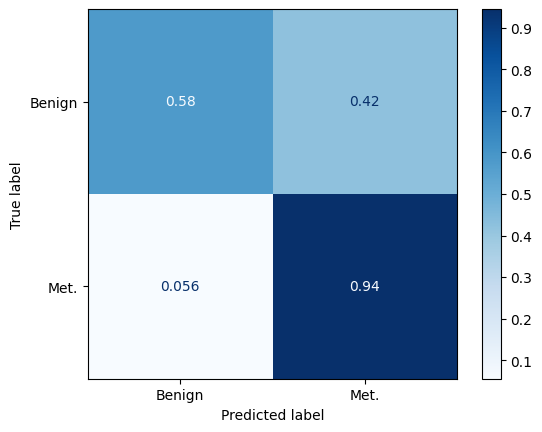

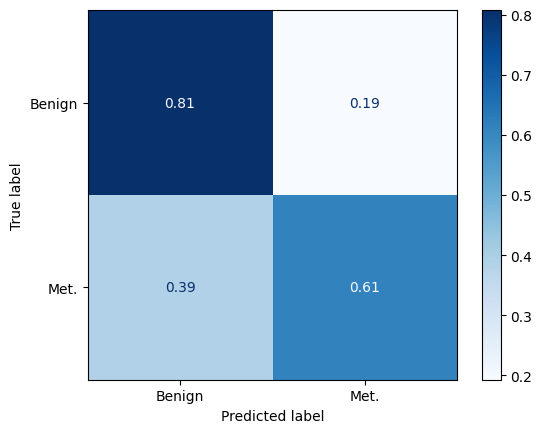

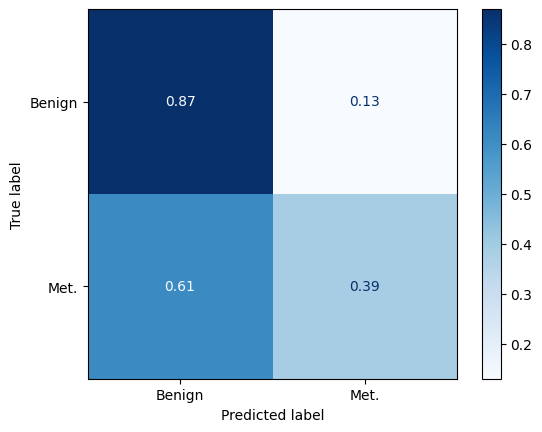

In [52]:
# CGMH
tcga_r1_met_cm, tcga_r1_ene_cm = generate_reader_confusion_mat(df_rd1_tcga, df_tcga, dataset='tcga')
tcga_r2_met_cm, tcga_r2_ene_cm = generate_reader_confusion_mat(df_rd2_tcga, df_tcga, dataset='tcga')
tcga_r4_met_cm, tcga_r4_ene_cm = generate_reader_confusion_mat(df_rd4_tcga, df_tcga, dataset='tcga')
tcga_r5_met_cm, tcga_r5_ene_cm = generate_reader_confusion_mat(df_rd5_tcga, df_tcga, dataset='tcga')
tcga_r6_met_cm, tcga_r6_ene_cm = generate_reader_confusion_mat(df_rd6_tcga, df_tcga, dataset='tcga')

for ridx in [1,2,4,5,6]:
    disp = ConfusionMatrixDisplay(confusion_matrix=eval("tcga_r{}_met_cm".format(ridx)), display_labels=['Benign', 'Met.'])
    disp.plot(cmap=plt.cm.Blues)
    plt.savefig("tcga_met_reader{}.svg".format(ridx))

# Algorithm

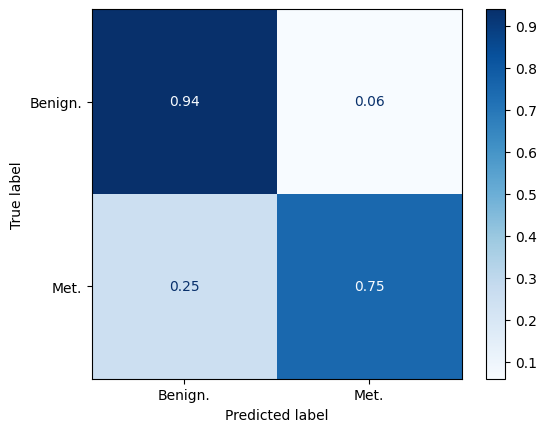

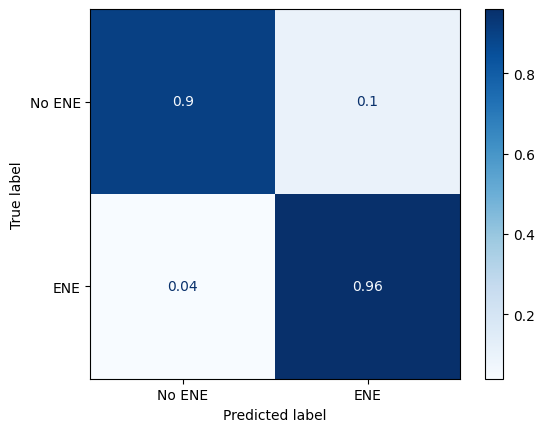

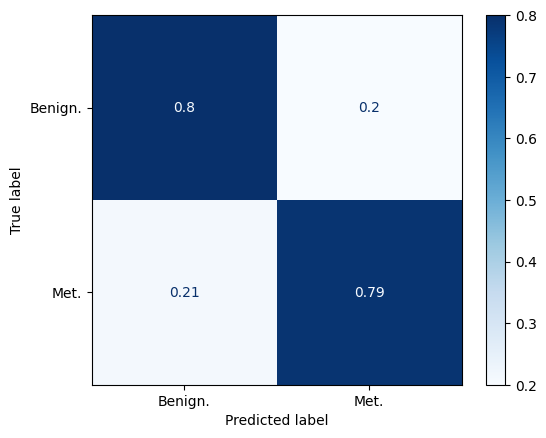

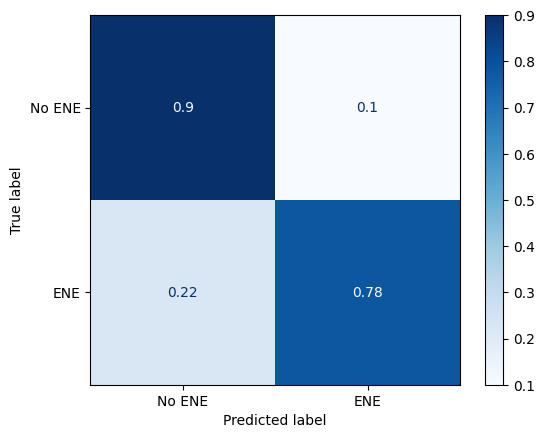

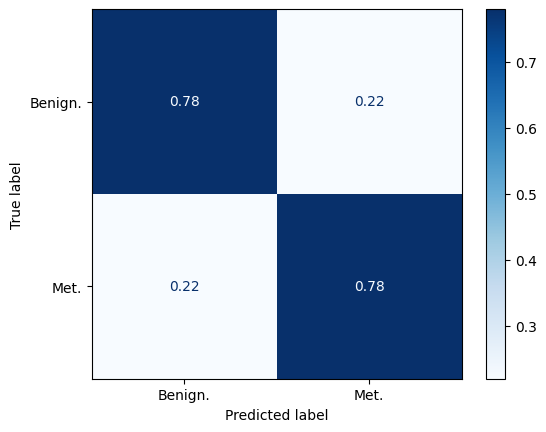

In [60]:
dl_renji_met_cm = np.array([[0.94, 1-0.94],[1-0.75, 0.75]])
disp = ConfusionMatrixDisplay(confusion_matrix=dl_renji_met_cm, display_labels=['Benign.', 'Met.'])
disp.plot(cmap=plt.cm.Blues)
plt.savefig("dl_renji_met.svg".format(ridx))

dl_renji_ene_cm = np.array([[0.9, 1-0.9],[1-0.96, 0.96]])
disp = ConfusionMatrixDisplay(confusion_matrix=dl_renji_ene_cm, display_labels=['No ENE', 'ENE'])
disp.plot(cmap=plt.cm.Blues)
plt.savefig("dl_renji_ene.svg".format(ridx))

dl_cgmh_met_cm = np.array([[0.8, 1-0.8],[1-0.79, 0.79]])
disp = ConfusionMatrixDisplay(confusion_matrix=dl_cgmh_met_cm, display_labels=['Benign.', 'Met.'])
disp.plot(cmap=plt.cm.Blues)
plt.savefig("dl_cgmh_met.svg".format(ridx))

dl_cgmh_ene_cm = np.array([[0.9, 1-0.9],[1-0.78, 0.78]])
disp = ConfusionMatrixDisplay(confusion_matrix=dl_cgmh_ene_cm, display_labels=['No ENE', 'ENE'])
disp.plot(cmap=plt.cm.Blues)
plt.savefig("dl_cgmh_ene.svg".format(ridx))

dl_tcga_met_cm = np.array([[0.78,1-0.78],[1-0.78, 0.78]])
disp = ConfusionMatrixDisplay(confusion_matrix=dl_tcga_met_cm, display_labels=['Benign.', 'Met.'])
disp.plot(cmap=plt.cm.Blues)
plt.savefig("dl_tcga_met.svg".format(ridx))